## Whale Sound Exploration

In this tutorial we will explore some data which contain right whale up-calls. The dataset was shared as part of a [2013 Kaggle competition](https://www.kaggle.com/c/whale-detection-challenge). Our goal is not to show the best winning algorithm to detect a call, but share a simple pipeline for processing oscillatory data, which possibly can be used on wide range of time series.

Objectives:
* read and extract features form audio data
* apply dimensionality reduction techiques
* perform supervised classification
* learn how to evaluate machine learning models
* train a neural network to detect whale calls

### Data Loading and Exploration
---

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# importing scientific python packages
import numpy as np

In [5]:
# import a library to read the .aiff format
import aifc

The `train` folder contains many `.aiff` files (2 second snippets) and we have `.csv` document which contains the corresponding labels. 

In [6]:
# !wget http://oceanhackweek2018.s3.amazonaws.com/oceans_data/train.tar.gz
# !wget http://oceanhackweek2018.s3.amazonaws.com/oceans_data/labels.csv

In [7]:
pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import gdown
gdown.download(id="1X4b6ArGJvbWFfe0c7eFGTS0umC2Dns-p")


Downloading...
From: https://drive.google.com/uc?id=1X4b6ArGJvbWFfe0c7eFGTS0umC2Dns-p
To: /content/train.tar.gz
100%|██████████| 64.2M/64.2M [00:00<00:00, 82.3MB/s]


'train.tar.gz'

In [9]:
gdown.download(id="1reml8qESFeS4buc_h3wfF9O4M2p30g3e", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1reml8qESFeS4buc_h3wfF9O4M2p30g3e
To: /content/labels.csv
100%|██████████| 540k/540k [00:00<00:00, 5.61MB/s]


'labels.csv'

In [10]:
!tar xvzf train.tar.gz

Streaming output truncated to the last 5000 lines.
train/train05000.aiff
train/train05001.aiff
train/train05002.aiff
train/train05003.aiff
train/train05004.aiff
train/train05005.aiff
train/train05006.aiff
train/train05007.aiff
train/train05008.aiff
train/train05009.aiff
train/train05010.aiff
train/train05011.aiff
train/train05012.aiff
train/train05013.aiff
train/train05014.aiff
train/train05015.aiff
train/train05016.aiff
train/train05017.aiff
train/train05018.aiff
train/train05019.aiff
train/train05020.aiff
train/train05021.aiff
train/train05022.aiff
train/train05023.aiff
train/train05024.aiff
train/train05025.aiff
train/train05026.aiff
train/train05027.aiff
train/train05028.aiff
train/train05029.aiff
train/train05030.aiff
train/train05031.aiff
train/train05032.aiff
train/train05033.aiff
train/train05034.aiff
train/train05035.aiff
train/train05036.aiff
train/train05037.aiff
train/train05038.aiff
train/train05039.aiff
train/train05040.aiff
train/train05041.aiff
train/train05042.aiff
tra

In [11]:
# read the audio filenames
filenames = sorted(glob(os.path.join('train','*.aiff')))
print('There are '+str(len(filenames))+' files.' )

There are 9999 files.


In [12]:
# read the labels
import pandas as pd
labels = pd.read_csv(os.path.join('labels.csv'), index_col = 0)

The format of the labels is:

In [13]:
labels.head(10)

,label
clip_name,
train00001.aiff,0
train00002.aiff,0
train00003.aiff,0
train00004.aiff,0
train00005.aiff,0
train00006.aiff,1
train00007.aiff,1
train00008.aiff,0
train00009.aiff,1


Let's look at one of those files.

In [14]:
# reading the file info
whale_sample_file = 'train00006.aiff'
whale_aiff = aifc.open(os.path.join('train',whale_sample_file),'r')
print ("Frames:", whale_aiff.getnframes() )
print ("Frame rate (frames per second):", whale_aiff.getframerate())

Frames: 4000
Frame rate (frames per second): 2000


Text(0.5, 0, 'Frame number')

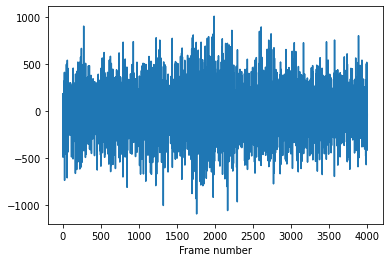

In [15]:
# reading the data
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
plt.plot(whale_array)
plt.xlabel('Frame number')

In [16]:
signal = whale_array.astype('float64')

In [17]:
# playing a whale upcall in the notebook
from IPython.display import Audio
# Audio(signal, rate=3000, autoplay = True)# the rate is set to 3000 make the widget to run (seems the widget does not run with rate below 3000)

Working directly with the signals is hard (there is important frequency information). Let's calculate the spectrograms for each of the signals and use as features.

In [18]:
# a function for plotting spectrograms
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]
    im = pl.imshow(Z, extent=extent,cmap = 'plasma')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

Text(0.5, 1.0, 'Spectrogram with an Upcall')

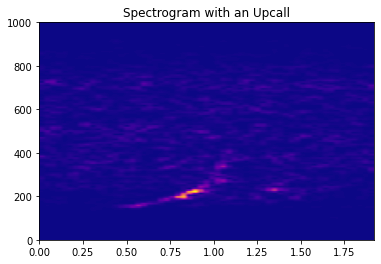

In [19]:
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)
plt.title('Spectrogram with an Upcall')

### Feature Extraction
---

We will go through the files and extract the spectrograms from each of them. We will do it for the first N files.

In [20]:
N = 10000 #number of files to use

In [21]:
# create a dictionary which contains all the spectrograms, labeled by the filename
spec_dict = {}

# threshold to cut higher frequencies
m = 60

# loop through all the files
for filename in filenames[:N]:
    # read the file
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    # create the spectrogram
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P[:m,:]

# save the dimensions of the spectrogram
spec_dim = P[:m,:].shape    

Most machine learning algorithms in Python expect the data to come in a format **observations** x **features**. In order to get the data in this format we need to convert the two-dimensional spectrogram into a long vector. For that we will use the `ravel` function.

In [22]:
# We will put the data in a dictionary
feature_dict = {}
for key in filenames[:N]:
    # vectorize the spectrogram
    feature_dict[key.split('/')[-1]] = spec_dict[key].ravel()

# convert to a pandas dataframe
X = pd.DataFrame(feature_dict).T

In [23]:
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539
train00001.aiff,0.133811,0.072258,0.109525,0.084067,0.139019,0.091778,0.259104,0.067828,0.111568,0.091280,...,323.757739,177.865058,69.035604,236.470513,95.348852,45.818186,62.494202,58.682033,27.582614,13.677962
train00002.aiff,0.020418,0.028692,0.106837,0.106685,0.101734,0.112110,0.104971,0.107934,0.113314,0.110579,...,13.960107,6.620344,1.826725,12.591117,23.735274,22.399912,9.117025,12.191837,16.824196,0.404101
train00003.aiff,0.094505,0.087168,0.093006,0.152327,0.131468,0.042501,0.053550,0.099153,0.097915,0.093418,...,25.414674,54.308283,50.471178,39.791219,20.454269,60.480539,150.188974,100.698584,27.933017,51.114037
train00004.aiff,0.046272,0.051663,0.085813,0.087076,0.097217,0.102125,0.102598,0.103876,0.099584,0.096484,...,127.593808,154.603321,189.184693,44.923291,0.157068,6.241901,35.208415,66.001433,2.440332,119.455716
train00005.aiff,0.107677,0.112647,0.106642,0.099382,0.092492,0.104994,0.163441,0.138776,0.047680,0.044006,...,818.349811,638.316169,255.905318,223.662617,167.522139,47.816370,2.397212,14.882543,99.071426,27.578218


In [24]:
# we do not need these objects anymore so let's release them from memory
del feature_dict
del spec_dict

In [25]:
# let's save these variables for reuse
np.save('X.npy',X)
np.save('y.npy',np.array(labels['label'][X.index])[:N])

### References:

https://www.kaggle.com/c/whale-detection-challenge

https://github.com/jaimeps/whale-sound-classification